introduction

the Facebook Recruiting IV Kaggle Challenge, "Human or Robot?" 
This project revolves around addressing the critical issue of computer-generated bidding in online auctions. The objective is to aid site owners in identifying and eliminating robotic bids, ensuring a fair and equitable auction platform. Despite previous attempts using behavioral data, the existing model has proven insufficient. Join me in exploring advanced techniques and methodologies employed to enhance predictive models, presenting a valuable addition to my portfolio as a data scientist committed to solving real-world challenges in the digital landscape.


Entropy 

N!/N_1!N_2!....N_n!


N is the total number of bids and N_n is the total number of bids placed from the nth IP.

Entropy is a metric that gauges the randomness and diversity of bids, considering factors such as the distribution of bids, the number of unique IPs, and the overall bid count. When a bidder consistently places bids from a single IP, the entropy is minimal, represented by a value of 1, as there is no variation. Due to the potentially large values of entropy, it is often more practical to compute the logarithm of the entropy for better interpretability and ease of comparison.

The provided Python code is an ETL (Extract, Transform, Load) process for feature engineering on bidding data to prepare it for a machine learning model. Below is a summary of the key steps and transformations performed in the code:

Data Preprocessing:

The bids data is sorted based on the auction and time.
Initial transformations are applied to determine the duration of each auction.
Time-related Features:

Features such as t_acabar (time to auction end) and t_iniciado (time since auction start) are calculated and aggregated at the bidder level.
Bidding Patterns Analysis:

The code explores the bidding patterns over time, distinguishing between human and bot behavior.
Three peaks in the bidding distribution are identified and visualized.
Linear Regression for Time Units:

Linear regression is used to estimate the time unit (e.g., a day) based on the time distribution.
The dataset is then labeled with the corresponding time unit.
Bids Per Time Unit:

The number of bids made by each bidder during specific time units (e.g., days) is calculated.
Bids Distribution Within a Week:

Bids are grouped by days of the week (Monday, Tuesday, Wednesday), and a balance feature is derived.
Bids Per Time Period:

Bids are categorized into specific time periods (e.g., every 20-minute intervals).
Time Intervals Between Bids:

Time intervals between consecutive bids within the same auction, same bidder, different auction but same bidder, and different bidder but same auction are calculated.
Mean and median values are computed at the bidder level.
Bids Per Auction:

Features related to bids per auction, such as mean and median, are calculated.
URL and IP Related Features:

Unique and total counts of URLs and IPs are computed.
Entropy measures for URLs and IPs are calculated.
Outcome Variable Adjustment:

The final dataset is merged with the original training data, and additional features are added.
Some NaN values are handled appropriately.
Saving Processed Data:

The resulting dataset is saved as 'etl_train.csv' for further analysis and model training.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

#load the data
bids=pd.read_csv('bids.csv')
bids = bids.sort_values(['auction', 'time'])

In [2]:
print(" bids columns:")
print(bids.head(5))


print("\nBids shape")
print(bids.shape)

unique_values_count = bids.nunique()
print("\nNumber of unique values in each column:")
print(unique_values_count)

null_values_count = bids.isnull().sum()
print("\nNumber of null values in each column:")
print(null_values_count)

 bids columns:
          bid_id                              bidder_id auction  \
5826422  5826422  92af1e40713e077ef87f5352fb56772fjnzm7   00270   
5834284  5834284  a939f51234ad2c44eb9ccc84e754f41foiv7g   00270   
5850448  5850448  92af1e40713e077ef87f5352fb56772fjnzm7   00270   
5884054  5884054  9655ccc7c0c193f1549475f02c54dce45kjw7   00270   
5898318  5898318  9655ccc7c0c193f1549475f02c54dce45kjw7   00270   

            merchandise     device              time country               ip  \
5826422          mobile   phone563  9699049894736842      us   78.188.245.105   
5834284          mobile    phone63  9699098210526315      us   12.142.135.122   
5850448          mobile   phone735  9699195789473684      us     2.86.254.154   
5884054  sporting goods   phone573  9699392473684210      us  149.152.163.145   
5898318  sporting goods  phone2294  9699474473684210      us   219.254.45.139   

                     url  
5826422  vuaaeraf3dqz299  
5834284  fbpq1mgtpgnkqnk  
5850448  nn2g5

In [3]:
# load the train and test files
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test['outcome']=-1
train=pd.concat([train,test])
train.head(5)

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


explain what this methods do

In [5]:
def fac_div_fac(x, y):
    if x == 0:
        x = 1
    if y == 0:
        y = 1

    if x > y:
        return np.sum(np.log(1.0 * np.array(range(int(y + 1), int(x + 1)))))
    if y > x:
        return -np.sum(np.log(1.0 * np.array(range(int(x + 1), int(y + 1)))))
    return 0.0


def balance(x):
    #	x['balance'] = np.std(x)/np.sqrt(np.mean(x))
    prueba=np.sum(x) / len(x)
    x0 = int(np.floor(np.sum(x) / len(x)))
    base = x0 * np.ones(len(x))
    
    base[0:int(np.sum(x) - x0 * len(x))] = x0 + 1

    b = 0.0
    for i in range(len(x)):
        # print base[i], x[i]
        b += fac_div_fac(base[i], x[i])

    # print b
    x['balance'] = b

    return x


def log_entropy(x):
    #x:(indice,valor)
    e = np.sum(np.log(np.array(range(1, np.sum(x)))))
    for i in x:
        e -= np.sum(np.log(np.array(range(1, i))))

    return e

the aproach would be that from bids i will create the features that will be able to determine which user is a bot.

In [6]:
# determine auction duration

a=bids.groupby(['auction']).time.min().reset_index()
a=a.rename(columns={'time':'t_start'})
a2=bids.groupby('auction').time.max().reset_index()
a2=a2.rename(columns={'time':'t_end'})
a=pd.merge(a,a2,how='left',on='auction')
#times['duration'] = times.endt - times.startt
a['duration']=a['t_end']-a['t_start']

#filter auctions that didnt start
auctions_no_iniciadas=a[a['duration']==0]
a=a[a['duration']!=0]


#add a features to bids dataframe
bids=pd.merge(bids,a,how='left',on='auction')
bids['t_end']=bids.t_end-bids.time
bids['t_init']=bids.time-bids.t_start

# features realted with end auction time
a=bids.groupby(['bidder_id','auction']).t_end.min().reset_index()
b=a.groupby('bidder_id').mean().reset_index()
b=b.rename(columns={'t_end':'min_mean_t_end'})
train=pd.merge(train,b,how='left',on='bidder_id')
b=a.groupby('bidder_id').median().reset_index()
b=b.rename(columns={'t_end':'min_median_t_end'})
train=pd.merge(train,b,how='left',on='bidder_id')

# features realted with init auction time
a=bids.groupby(['bidder_id','auction']).t_init.min().reset_index()
b=a.groupby('bidder_id').mean().reset_index()
b=b.rename(columns={'t_init':'min_mean_t_start'})
train=pd.merge(train,b,how='left',on='bidder_id')
b=a.groupby('bidder_id').median().reset_index()
b=b.rename(columns={'t_init':'min_median_t_start'})
train=pd.merge(train,b,how='left',on='bidder_id')

# mean and median end time by user
b=bids.groupby('bidder_id').t_end.mean().reset_index()
b=b.rename(columns={'t_end':'mean_t_end'})
train=pd.merge(train,b,how='left',on='bidder_id')
b=bids.groupby('bidder_id').t_end.median().reset_index()
b=b.rename(columns={'t_end':'median_t_end'})
train=pd.merge(train,b,how='left',on='bidder_id')

# mean and median init time by user
b=bids.groupby('bidder_id').t_init.mean().reset_index()
b=b.rename(columns={'t_iniciado':'mean_t_start'})
train=pd.merge(train,b,how='left',on='bidder_id')
b=bids.groupby('bidder_id').t_init.median().reset_index()
b=b.rename(columns={'t_iniciado':'median_t_start'})
train=pd.merge(train,b,how='left',on='bidder_id')


<ipython-input-7-1fd035a5e9d9>:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  botp = np.histogram(bot, 3000, range=[bot.min()-delta,bot.max()+delta], normed=True)
<ipython-input-7-1fd035a5e9d9>:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  humanp = np.histogram(human, 3000, range=[human.min()-delta,human.max()+delta], normed=True)


Text(0.5, 1.0, 'bids over time')

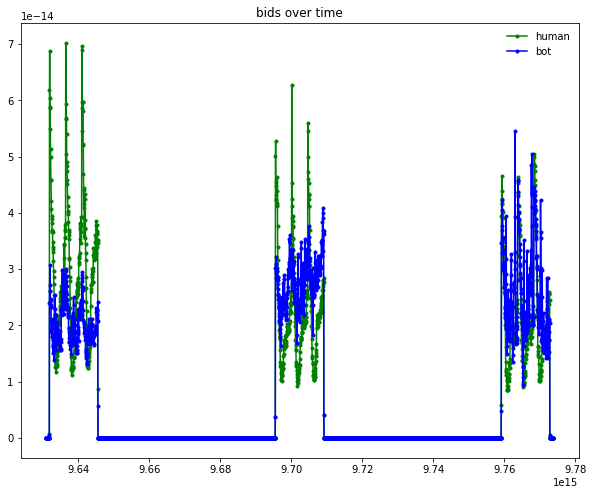

In [7]:
# data exploration

bots=train[train.outcome==1].bidder_id.values
humans=train[train.outcome==0].bidder_id.values
bot=bids[bids.bidder_id.isin(bots)].time
human=bids[bids.bidder_id.isin(humans)].time
delta=1e12
botp = np.histogram(bot, 3000, range=[bot.min()-delta,bot.max()+delta], normed=True)
humanp = np.histogram(human, 3000, range=[human.min()-delta,human.max()+delta], normed=True)
no0=pd.DataFrame(humanp[0])
no0=no0[no0.iloc[:,0]!=0]

#plot of the entire data
plt.figure(figsize=(10, 8))
plt.plot(humanp[1][0:-1], humanp[0], 'g.-')
plt.plot(humanp[1][0:-1], botp[0], 'b.-')
plt.legend(['human','bot'], frameon=False)
plt.title('bids over time')



the time column for this challenge doest have any units. from the data it can be seen that the are 3 moments for auctions. It is assumed that each chunck of data could be a day. This is because the duration of each auction has the same length. The duration of the entire data set is 31 times the lenght of an auction (one day). 

9772885210526315
9631916842105263


<ipython-input-8-f35ad7575f6e>:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  botp2 = np.histogram(bot, 300, range=[bot.min()-delta,botp[1][440]+delta*0.2], normed=True)
<ipython-input-8-f35ad7575f6e>:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  humanp2 = np.histogram(human, 300, range=[human.min()-delta,humanp[1][440]+delta*0.2], normed=True)


Text(0.5, 1.0, 'bids over time')

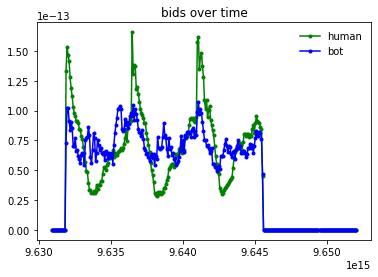

In [8]:
#plot for one of the days
f=botp[1][440]
botp2 = np.histogram(bot, 300, range=[bot.min()-delta,botp[1][440]+delta*0.2], normed=True)
humanp2 = np.histogram(human, 300, range=[human.min()-delta,humanp[1][440]+delta*0.2], normed=True)
plt.plot(humanp2[1][0:-1], humanp2[0], 'g.-')
plt.plot(humanp2[1][0:-1], botp2[0], 'b.-')
botp3 = np.histogram(bot, 4000, range=[bot.min()-delta,bot.max()+delta])
humanp3 = np.histogram(human, 4000, range=[human.min()-delta,human.max()+delta])
print(bot.max())
print(bot.min())
plt.legend(['human','bot'], frameon=False)
plt.title('bids over time')

as there is no unit for the time its better to create a unit and the start creating features with respect to this unit. the following code lets to identify the day and the week of each bid

In [9]:
#calculate a day by linear regression 
t0=bot.min()
day3=bids[bids['time']<=botp3[1][410]]
day3=day3.sort_values('time',ascending=False)
day3=day3['time'].iloc[0]


t=botp3[1][1809]
t2=botp3[1][1808]

day14=bids[bids['time']<=botp3[1][1810]]
day14=day14[day14['time']>=botp3[1][1808]]
day14=day14.sort_values('time',ascending=True)
day14=day14['time'].iloc[0]

day17=bids[bids['time']<=botp3[1][2191]]
day17=day17.sort_values('time',ascending=False)
day17=day17['time'].iloc[0]

day28=bids[bids['time']<=botp3[1][3591]]
day28=day28[day28['time']>=botp3[1][3589]]
day28=day28.sort_values('time',ascending=True)
day28=day28['time'].iloc[0]

day31=bids[bids['time']<=botp3[1][3973]]
day31=day31.sort_values('time',ascending=False)
day31=day31['time'].iloc[0]

unidad_x=np.array([t0,day3,day14,day17,day28,day31])
days=np.array([0,3,14,17,28,31]).reshape((-1,1))

clf = LinearRegression(fit_intercept=True)
clf.fit(days, unidad_x)
day0=np.array([0])
day1=np.array([1])
startt=clf.predict(day0.reshape((-1,1)))
startt2=clf.predict(day1.reshape((-1,1)))
day =(startt2-startt)


bids['day']=np.floor((bids.time-startt)/day)
bids['week']=np.floor((bids.day/7))
print('weeks ',bids.week.unique())
dayu=bids.day.unique()
weeks=bids.week.unique()
print('days ',dayu)

weeks  [2. 4. 0.]
days  [14. 15. 16. 28. 29. 30.  0.  1.  2.]


The day of the month is already known. it also will be helpful to recognize the weekday in order to find any pattern

In [10]:
b=bids.groupby(['bidder_id','day']).size().reset_index()
b=b.rename(columns={0:'bids_por_dia'})
b=b.pivot('bidder_id','day','bids_por_dia').fillna(0).reset_index()
old_columns=b.columns.values
new_columns=[b.columns[0]]

for i in range(1,len(b.columns)):
    new_columns.append(str(int(old_columns[i]))+'_day')
b=b.rename(columns=dict(zip(old_columns, new_columns)))
b['monday'] = (b['0_day'] + b['14_day'] + b['28_day']).fillna(0)
b['tuesday'] = (b['1_day'] + b['15_day'] + b['29_day']).fillna(0)
b['wednesday'] = (b['2_day'] + b['16_day'] + b['30_day']).fillna(0)
b['balance'] = b[['monday', 'tuesday', 'wednesday']].apply(balance, axis=1)[['balance']]

train=pd.merge(train,b,how='left',on='bidder_id')
train[['monday', 'tuesday', 'wednesday', 'balance']] = train[['monday', 'tuesday', 'wednesday', 'balance']].fillna(0)


s = train.loc[:, ['monday', 'tuesday', 'wednesday']].max(axis=1)
train['s_monday'] = train['monday'] / s
train['s_tuesday'] = train['tuesday'] / s
train['s_wednesday'] = train['wednesday'] / s

s = train.loc[:, ['monday', 'tuesday', 'wednesday']].sum(axis=1)
train['f_monday'] = train['monday'] / s
train['f_tuesday'] = train['tuesday'] / s
train['f_wednesday'] = train['wednesday'] / s

not only i necessary to get the weekday but also the behaviour in minutes. bot may place bids faster. the following features were calculated:



time betweeen bids from the same auction
time between bids from different bidders from the same auction
time between bids from same bidder for every auction
calculate the mean bids per auction for every id


how to calculate time
units to hour
x units * 1 day/4547368124071.879 units * 24hr/1 day = hours

other possibiliites can be 30 min replacing 24 by 48 or 20 min replacing 24 by 72

In [103]:
#Bid in a specific period n=24 hours, n=48 30 min, n=72 20 min
n=72

bids_por_tiempo=np.floor(np.mod(bids.time-t0,day)*n/day)
bids_por_tiempo.name = 'franja'
bids=pd.concat([bids,bids_por_tiempo],axis=1)

b = bids.groupby(['bidder_id', 'franja']).size().reset_index()
b=b.rename(columns={0:'countfranja72'})
b=b.pivot('bidder_id','franja','countfranja72').fillna(0).reset_index()
old_names=b.columns.values
new_names=b.columns.values

for i in range(1,len(b.columns)):
    new_names[i]=str(int(new_names[i]))+'_de_'+str(n)

b = b.rename(columns=dict(zip(old_names, new_names)), inplace=False)
b['max_bids_por_hora']=b.iloc[:,1:].max(axis=1)
train=pd.merge(train,b,how='left',on='bidder_id')


for week in [0,2,4]:
    b=bids[bids.week==week].sort_values(['auction','time'])
    t_prev=np.append([np.nan],b.time.values[0:-1])
    b['dt_auction']=b.time-t_prev
    auction_prev=np.append([np.nan],b.auction.values[0:-1])
    b['auction_antes']=auction_prev
    if week==0:
        c=[b[b.auction==b.auction_antes]]
    else:
        c.append(b[b.auction==b.auction_antes])
   



In [104]:
#c=pd.DataFrame(c)
#time betweeen bids from the same auction
c=pd.concat(c)
d=c.groupby(['bidder_id']).dt_auction.mean().reset_index()
d=d.rename(columns={'dt_auction':'dt_mean_sig'})
d2=c.groupby(['bidder_id']).dt_auction.median().reset_index()
d2=d2.rename(columns={'dt_auction':'dt_median_sig'})
d2=d2.drop(columns=['bidder_id'])
d=pd.concat([d,d2],axis=1)
train=pd.merge(train,d,how='left',on='bidder_id')

#calculate 15s in x units. 86400 s in 1 day
t_threshold=day*15/86400
c['mean_sig_threshold']=np.nan
c.loc[c.dt_auction <= float(t_threshold), 'mean_sig_threshold'] = 1.0
c.loc[c.dt_auction > float(t_threshold), 'mean_sig_threshold'] = 0.0

a=c[['bidder_id','mean_sig_threshold']].dropna().groupby('bidder_id').mean().reset_index()
#a=c[c['bidder_id','dt_auction']].dropna().groupby('bidder_id').median().reset_index()
train=pd.merge(train,a[['bidder_id','mean_sig_threshold']],how='left',on='bidder_id')



# time between bids from different bidders and same auction

for week in [0,2,4]:

    a=bids[bids.week==week].sort_values(['auction','time'])
    t_prev=np.append([np.nan],a.time.values[0:-1])
    a['t_prev']=t_prev
    auction_prev=np.append([np.nan],a.auction.values[0:-1])
    a['auction_prev'] = auction_prev
    bidder_prev = np.append([np.nan], a.bidder_id.values[0:-1])
    a['bidder_prev'] = bidder_prev
    a['dt']=a.time-a.t_prev
    if week==0:
        c=[a[a.bidder_id!=a.bidder_prev][a.auction==a.auction_prev]]
    else:
        c.append(a[a.bidder_id!=a.bidder_prev][a.auction==a.auction_prev])
c=pd.concat(c)
d=c[['bidder_id','dt']].dropna().groupby(['bidder_id']).dt.mean().reset_index()
d=d.rename(columns={'dt':'dt_mean_bidder_differente'})
train=pd.merge(train,d,how='left',on='bidder_id')

d=c[['bidder_id','dt']].dropna().groupby(['bidder_id']).dt.median().reset_index()
d=d.rename(columns={'dt':'dt_median_bidder_differente'})
train=pd.merge(train,d,how='left',on='bidder_id')

# time between bids from same bidder for every auction

for week in [0,2,4]:
    a=bids[bids.week==week].sort_values(['bidder_id','time'])
    t_prev=np.append([np.nan],a.time.values[0:-1])
    a['t_prev']=t_prev
    bidder_prev=np.append([np.nan],a.bidder_id.values[0:-1])
    a['bidder_prev']=bidder_prev
    a['dt']=a.time-a.t_prev
    if week==0:
        c=[a[a.bidder_id==a.bidder_prev]]
    else:
        c.append(a[a.bidder_id==a.bidder_prev])

c=pd.concat(c)
d=c[['bidder_id','dt']].dropna().groupby('bidder_id').dt.mean().reset_index()
d=d.rename(columns={'dt':'dt_mean_same_bidder'})
train=pd.merge(train,d,how='left',on='bidder_id')

d=c[['bidder_id','dt']].dropna().groupby('bidder_id').dt.median().reset_index()
d=d.rename(columns={'dt':'dt_median_same_bidder'})
train=pd.merge(train,d,how='left',on='bidder_id')

d=c[['bidder_id','dt']].dropna().groupby('bidder_id').dt.min().reset_index()
d=d.rename(columns={'dt':'dt_min_same_bidder'})
train=pd.merge(train,d,how='left',on='bidder_id')

# calculate the mean bids per auction for every id

a=bids.groupby(['bidder_id','auction']).size().reset_index()
a=a.rename(columns={0:'bids_mean_auction'})
b=a.groupby(['bidder_id']).bids_mean_auction.mean().reset_index()
train=pd.merge(train,b,how='left',on='bidder_id')

b=a.groupby(['bidder_id']).bids_mean_auction.median().reset_index()
b=b.rename(columns={'bids_mean_auction':'bids_median_auction'})
train=pd.merge(train,b,how='left',on='bidder_id')

a=bids.groupby(['bidder_id']).size().reset_index()
a=a.rename(columns={0:'total_bids'})
train=pd.merge(train,a,how='left',on='bidder_id')

<ipython-input-104-14a5e5f0c799>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c=[a[a.bidder_id!=a.bidder_prev][a.auction==a.auction_prev]]
<ipython-input-104-14a5e5f0c799>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(a[a.bidder_id!=a.bidder_prev][a.auction==a.auction_prev])
<ipython-input-104-14a5e5f0c799>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(a[a.bidder_id!=a.bidder_prev][a.auction==a.auction_prev])


features related with url
unique urls per bidder
total urls per bidder
total urls per bidder/unique urls per bidder
entropy of url for each user bidder

In [105]:
#unique urls per bidder

a=bids.groupby(['bidder_id']).url.nunique().reset_index().fillna(1)
a=a.rename(columns={'url':'n_unique_url'})
train=pd.merge(train,a,how='left',on='bidder_id')

#urls used per bidder
a=bids.groupby('bidder_id').url.count().reset_index().fillna(1)
a=a.rename(columns={'url':'used_urls'})
train=pd.merge(train,a,how='left',on='bidder_id')


# numero urls/ numero urls unicas
train['f_urls']=train['used_urls']/train['n_unique_url']

# entropia de las urls para cada bidder
a = bids.groupby(['bidder_id', 'url']).size().reset_index()
a= a.rename(columns = {0:'url_count'})
a = a.groupby('bidder_id').url_count.apply(log_entropy).reset_index()
a= a.rename(columns = {'url_count':'url_entropy'})
train=pd.merge(train,a,how='left',on='bidder_id')

# entropy of url for each user bidder
a = bids.groupby(['bidder_id', 'url']).size().reset_index()
a= a.rename(columns = {0:'url_count'})
a = a.groupby('bidder_id').url_count.apply(log_entropy).reset_index()
a= a.rename(columns = {'url_count':'url_entropy'})
train=pd.merge(train,a,how='left',on='bidder_id')

feature related with users ip

In [106]:
#ip entropy
a=bids.groupby(['bidder_id','ip']).size().reset_index()
a=a.rename(columns={0:'ip_entropy'})
a=a.groupby('bidder_id').ip_entropy.apply(log_entropy).reset_index()
train=pd.merge(train,a,how='left',on='bidder_id')

create the file for training the model

In [107]:
train.to_csv('etl_train.csv',index=False)
print(train.shape)

(6713, 121)


the file had 9 features and now it has 121 feature for creating the model